In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *
from p_IMP_plot import *
import regionmask

In [14]:
# Your custom order
groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    'Global land': ['LSAT']

}

# Flatten region list in desired order
ordered_regions = [abbr for group in groups.values() for abbr in group]
ordered_groups = [group for group, regions in groups.items() for _ in regions]


In [16]:
def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

path = './saved_data/'
name = '1.0.1_IPM_Prior_posterier_Pseudo_warming_period_reg_lsat_47reg_2016-2025_ref1850-1900.pkl'

prior_post_all = load_xr_pickle(path + name)


prior = prior_post_all["prior_all_schemes"]
post = prior_post_all["post_all_schemes"]
pseudo = prior_post_all["pseudo_warming"].sel(region=ordered_regions)

prior_post_7scheme = xr.concat([post, prior.mean('scheme').expand_dims(scheme = ['prior'])], dim = 'scheme').squeeze().sel(region=ordered_regions)

prior_post_group = group_by_model_name(prior_post_7scheme, dim_name = 'model_name')

pseudo_group = group_by_model_name(pseudo, dim_name = 'model_name')
pseudo_group

[<xarray.DataArray 'pseudo_warming' (pseudo: 3, region: 47)> Size: 1kB
 array([[1.91725293, 2.15758632, 2.50221462, 1.61862192, 1.51360023,
         1.4319857 , 1.53111865, 1.09215408, 1.08713755, 1.43014787,
         1.80366189, 1.4499103 , 1.68692191, 1.1163757 , 1.34429588,
         0.85834713, 1.62986006, 1.76890342, 2.39276798, 1.51871182,
         2.04524934, 1.47651238, 1.71151123, 1.51012157, 1.58071883,
         1.49306207, 1.40391267, 1.22872094, 3.08444389, 2.2562567 ,
         2.03988368, 2.23113217, 1.6875752 , 1.66575338, 1.37217414,
         1.32070251, 2.00681513, 1.24206194, 1.18060166, 1.3493838 ,
         1.57995645, 1.51860092, 1.08174775, 1.22312152, 1.43937397,
         1.21475107, 1.63085598],
        [2.34194702, 1.85461805, 2.58254535, 1.72219879, 1.62529404,
         1.4199869 , 1.48007219, 1.09261964, 1.06958667, 1.38066222,
         1.62199018, 1.32688636, 1.5202015 , 1.03239884, 0.92090508,
         0.86396379, 1.95936863, 1.97085358, 1.43189981, 1.76831942

### Calculation

#### RMSE

In [20]:
path = './saved_data/'
mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

mod_45_pseudo = change_ref(mod_45_pseudo, 1850, 1900).sel(year = slice(2016, 2025)).mean('year')

mod_45_pseudo = mod_45_pseudo.assign_coords(
    region = ("region", mod_45_pseudo["abbrevs"].values)
)


In [21]:
pseudo_mean_smoothed = mod_45_pseudo.groupby('model_name').mean()
prior_post_group = prior_post_group

n_scheme = len(prior_post_group[0]['scheme'])
sq_errors_all = []
# for pseudo_id in range(len(pseudo_mean_smoothed)):
for pseudo_id in range(len(pseudo_mean_smoothed)):

    # reference pseudo mean
    pseudo_ref = pseudo_mean_smoothed[pseudo_id]
    post_mean = (
        prior_post_group[pseudo_id]
        .isel(scheme=slice(0, n_scheme))
        .sel(quantile='mean')
    )


    sq_errors = (post_mean - pseudo_ref)**2
    magnitude = pseudo_mean_smoothed[pseudo_id]
    scaled_sq_errors = sq_errors / (magnitude**2)

    # print(sq_errors)
    sq_errors_all.append(scaled_sq_errors)


sq_errors_all = xr.concat(sq_errors_all, dim = 'pseudo')
scaled_rmse_all = np.sqrt(sq_errors_all.sum(dim = 'pseudo')/ len(pseudo_ref))

scaled_rmse_all

confidence_all = 1/(scaled_rmse_all)


In [22]:
confidence_all

<xarray.DataArray (scheme: 2, region: 47)> Size: 752B
array([[ 3.82604989,  7.47586939,  6.22629994,  7.39845674,  3.23012653,
         8.74041358,  8.52503204, 15.380173  , 18.25491711, 12.92452192,
         7.45031747, 10.35957885,  6.52438816, 13.11214902, 10.40265857,
         9.28689728,  3.87961113,  6.70375698,  5.80024623,  8.68523717,
         9.35415138, 10.40863373,  7.46341935,  8.70390222,  8.06973667,
        11.20387239,  9.23305302, 13.57355669,  5.82772226,  6.22637219,
         6.40312249,  4.63257635,  7.74886769,  7.92873073,  5.73246872,
         7.59021175, 10.61862285,  7.18562648, 13.25338227, 12.15045723,
         7.66681953, 11.76015495,  9.59220182, 11.11684404,  4.64489459,
         1.75102895, 14.66650349],
       [ 3.89332706,  4.6217336 ,  5.70864238,  4.25731738,  1.48717344,
         5.36846282,  5.9257955 ,  7.45452568,  7.06852853,  5.68197491,
         4.7134522 ,  5.95574776,  5.76336635,  5.97066902,  4.40071064,
         4.64959809,  2.90045656,  4.54321699,  4.97798896,  4.91415624,
         6.09154106,  5.13985002,  4.60459424,  6.42476009,  7.33766349,
         6.3429585 ,  7.52304503,  7.46383844,  5.85916102,  5.05601322,
         5.7167522 ,  5.13861489,  4.88251411,  5.490741  ,  2.84947158,
         4.1646313 ,  6.32940934,  2.85240244,  5.75012316,  6.89658125,
         5.96787413,  7.73345588,  4.71496279,  5.27073043,  3.73611207,
         1.6732604 ,  6.19203986]])
Coordinates:
  * region        (region) <U4 752B 'GIC' 'NWN' 'NEN' ... 'EAN' 'WAN' 'LSAT'
  * scheme        (scheme) object 16B 'global_region' 'prior'
    quantile      <U4 16B 'mean'
    forcing       <U3 12B 'ALL'
    region_group  (region) <U25 5kB 'North and Central America' ... 'Global l...
    abbrevs       (region) <U4 752B 'GIC' 'NWN' 'NEN' ... 'EAN' 'WAN' 'LSAT'
    names         (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'

### Plot

#### Fig. 2

/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_52227/2776818770.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)


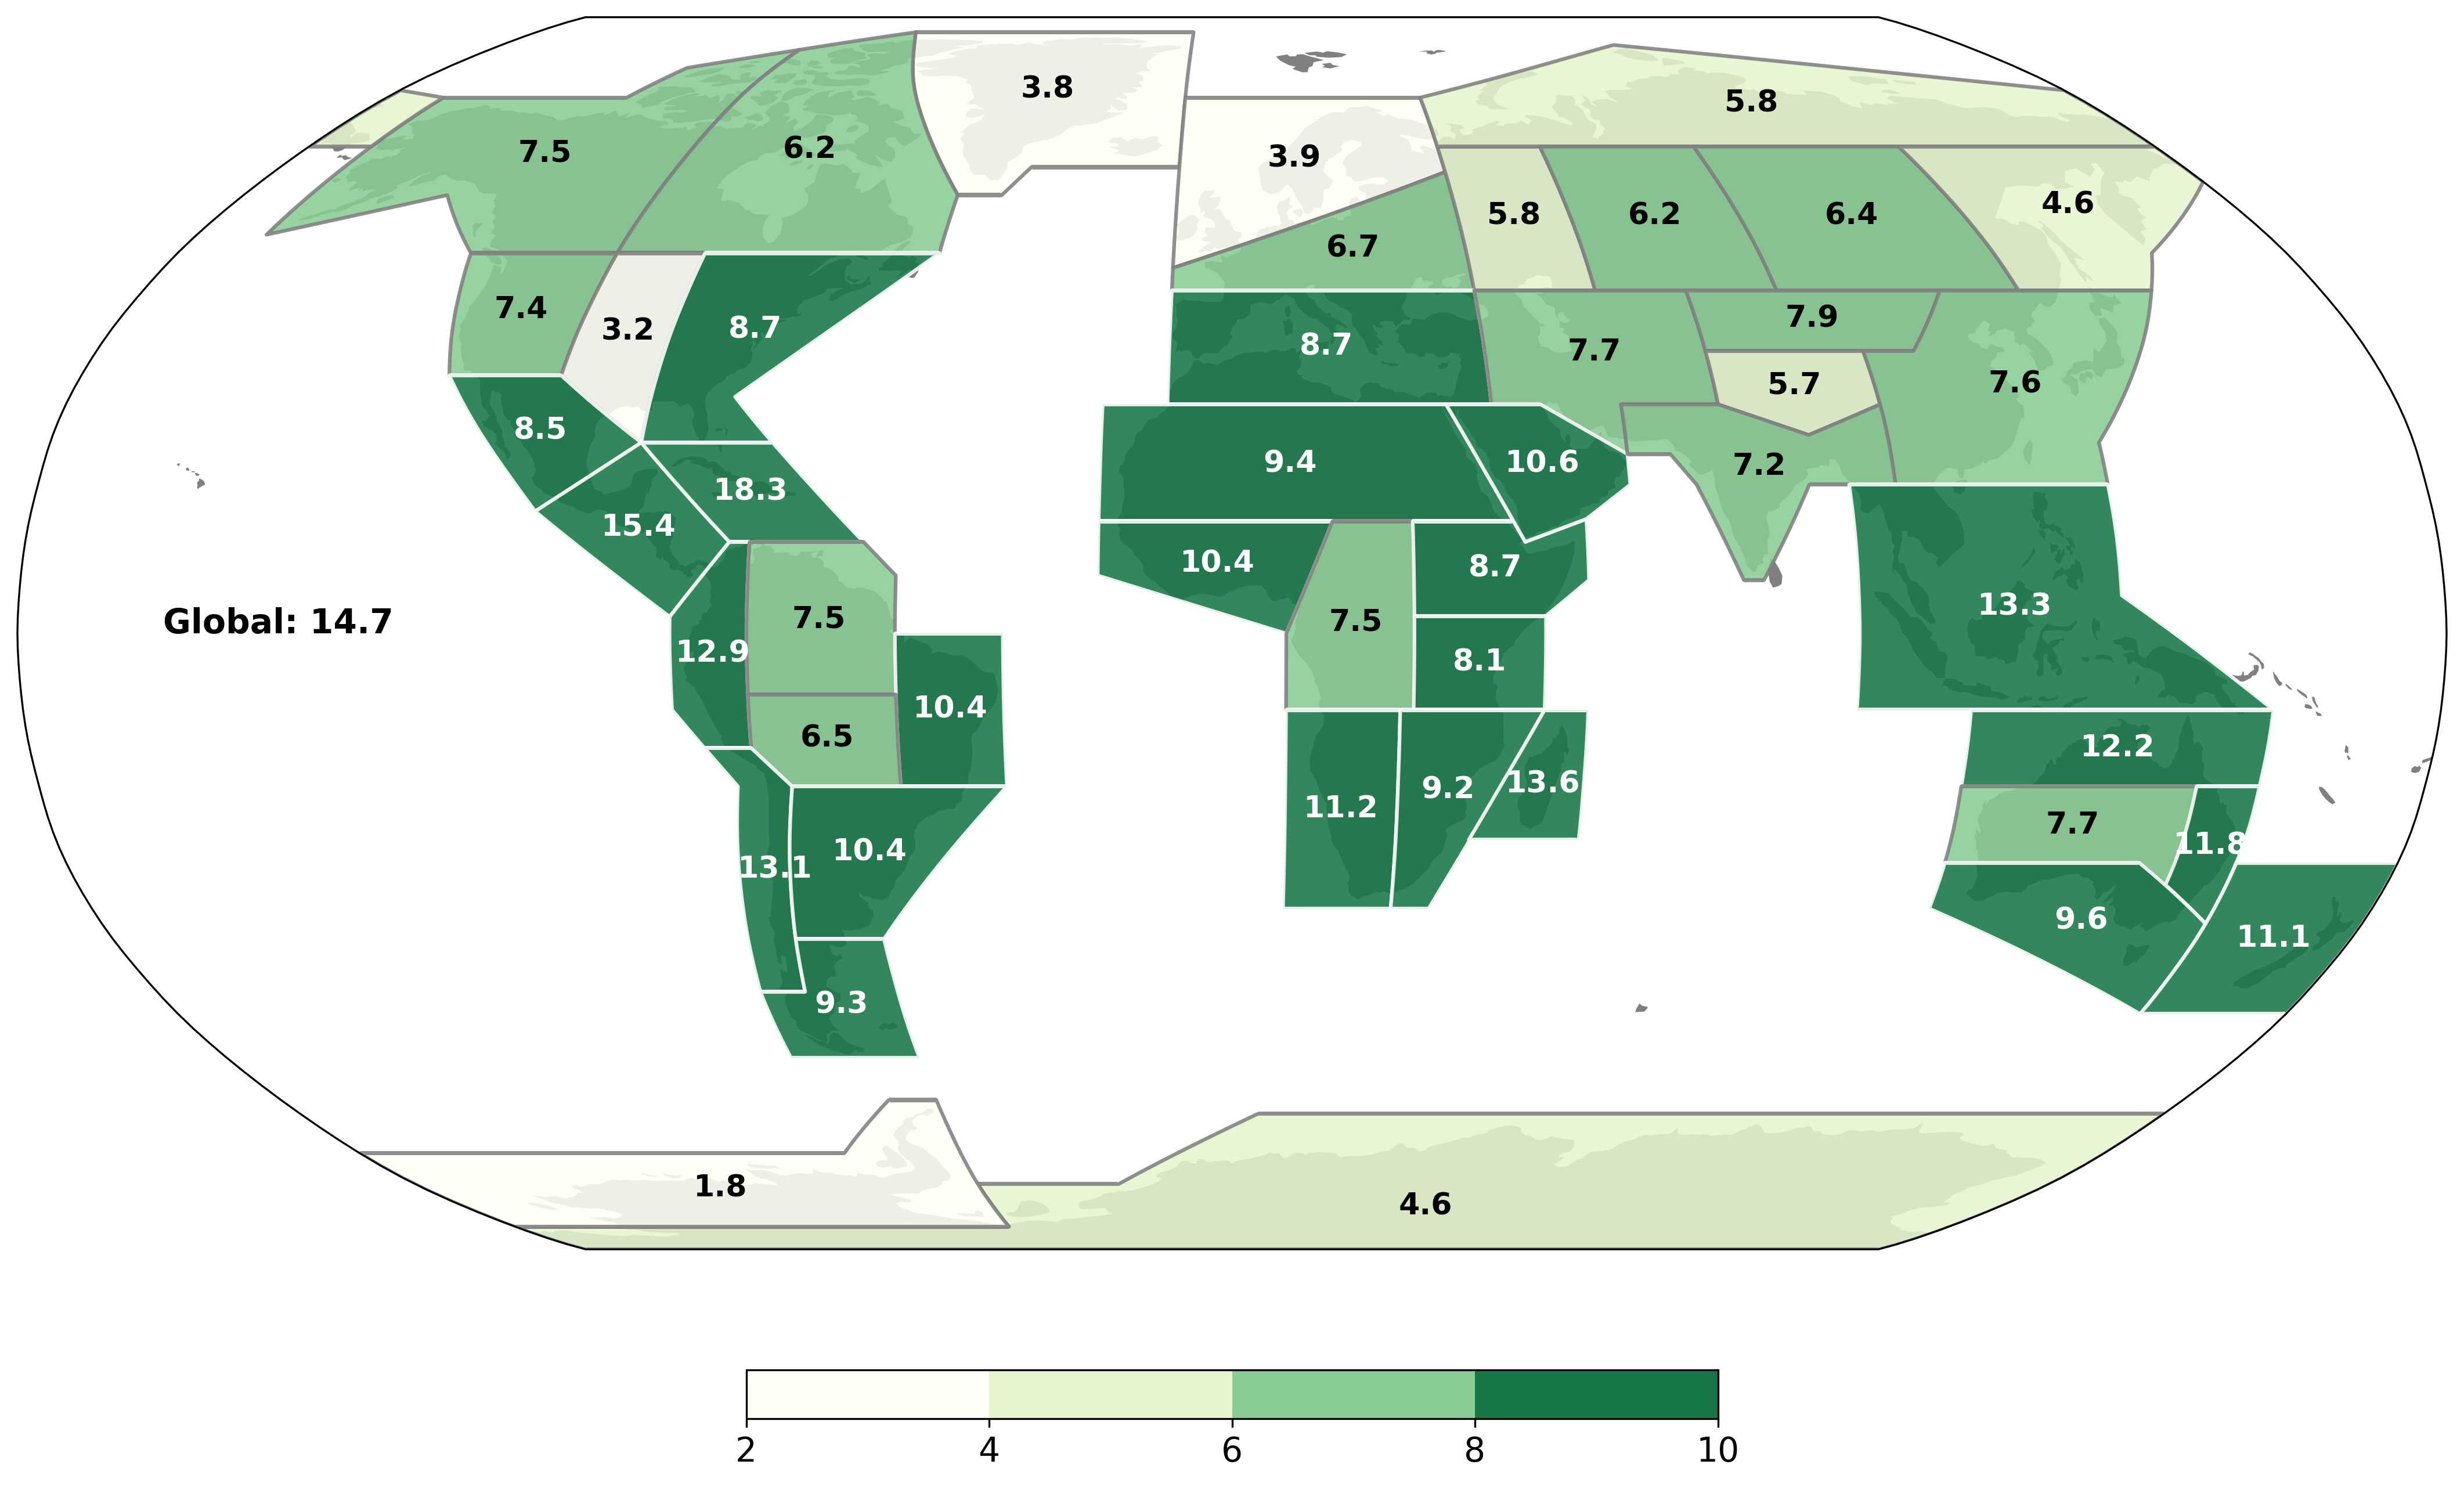

In [31]:
confidence_best = confidence_all.sel(scheme = 'global_region').isel(region = slice(0, 46))
global_value = confidence_all.sel(scheme = 'global_region').isel(region = 46)

unit = ' '
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Shared colorbar
cmap = sns.color_palette("OrRd", as_cmap=True)

# cmap = LinearSegmentedColormap.from_list("red_white", ["white", "#008000"])
def modify_cmap(name='YlGn', start=0.1, end=0.9, gamma=0.8, white_strength=0.3):
    """
    white_strength = 0 → no whitening
    white_strength = 1 → pure white at start
    """
    base = cm.get_cmap(name)
    colors = base(np.linspace(start, end, 256))[:, :3] ** gamma
    
    # Blend first colors toward white
    white = np.array([1, 1, 1])
    for i in range(len(colors)):
        blend_factor = (1 - i / (len(colors)-1)) * white_strength
        colors[i] = (1-blend_factor)*colors[i] + blend_factor*white
    
    return ListedColormap(colors)


cmap = modify_cmap('YlGn', start=0.0, end=0.95, gamma=1.0, white_strength=0.7)

colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[0:230]
truncated_cmap = colors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)

# --- Plot panels ---
fig, axes = plt.subplots(1,1, figsize=(18, 18), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)

axes.set_global()
# axes.coastlines(linewidth=0.5)

bounds = np.arange(2, 12, 2)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax_new(axes, confidence_best, cmap=truncated_cmap, norm=norm, decimals=1, region_shifts = {
    "SWS": (2.0, 0),   # (x_shift, y_shift)
    "EAU": (-0.5, 0) # another example
})


axes.text(
            0.06, 0.5,
            f"Global: {global_value:.1f}{unit}",   # unit inserted here
            transform=axes.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )


# axes.set_title("Confidence map (Warming magnitude / estimation error (RMSE) in 2016-2025 ref. to 1850-1900)", fontsize=14, fontweight='bold', loc='left')


# --- Shared colorbar ---
# Use a ScalarMappable with the colormap and norm
sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm0)
sm.set_array([])  # required for ScalarMappable

cb = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, shrink=0.4,)
cb.ax.tick_params(labelsize=14)

# cb.set_label("Number of valid grids")

plt.show()


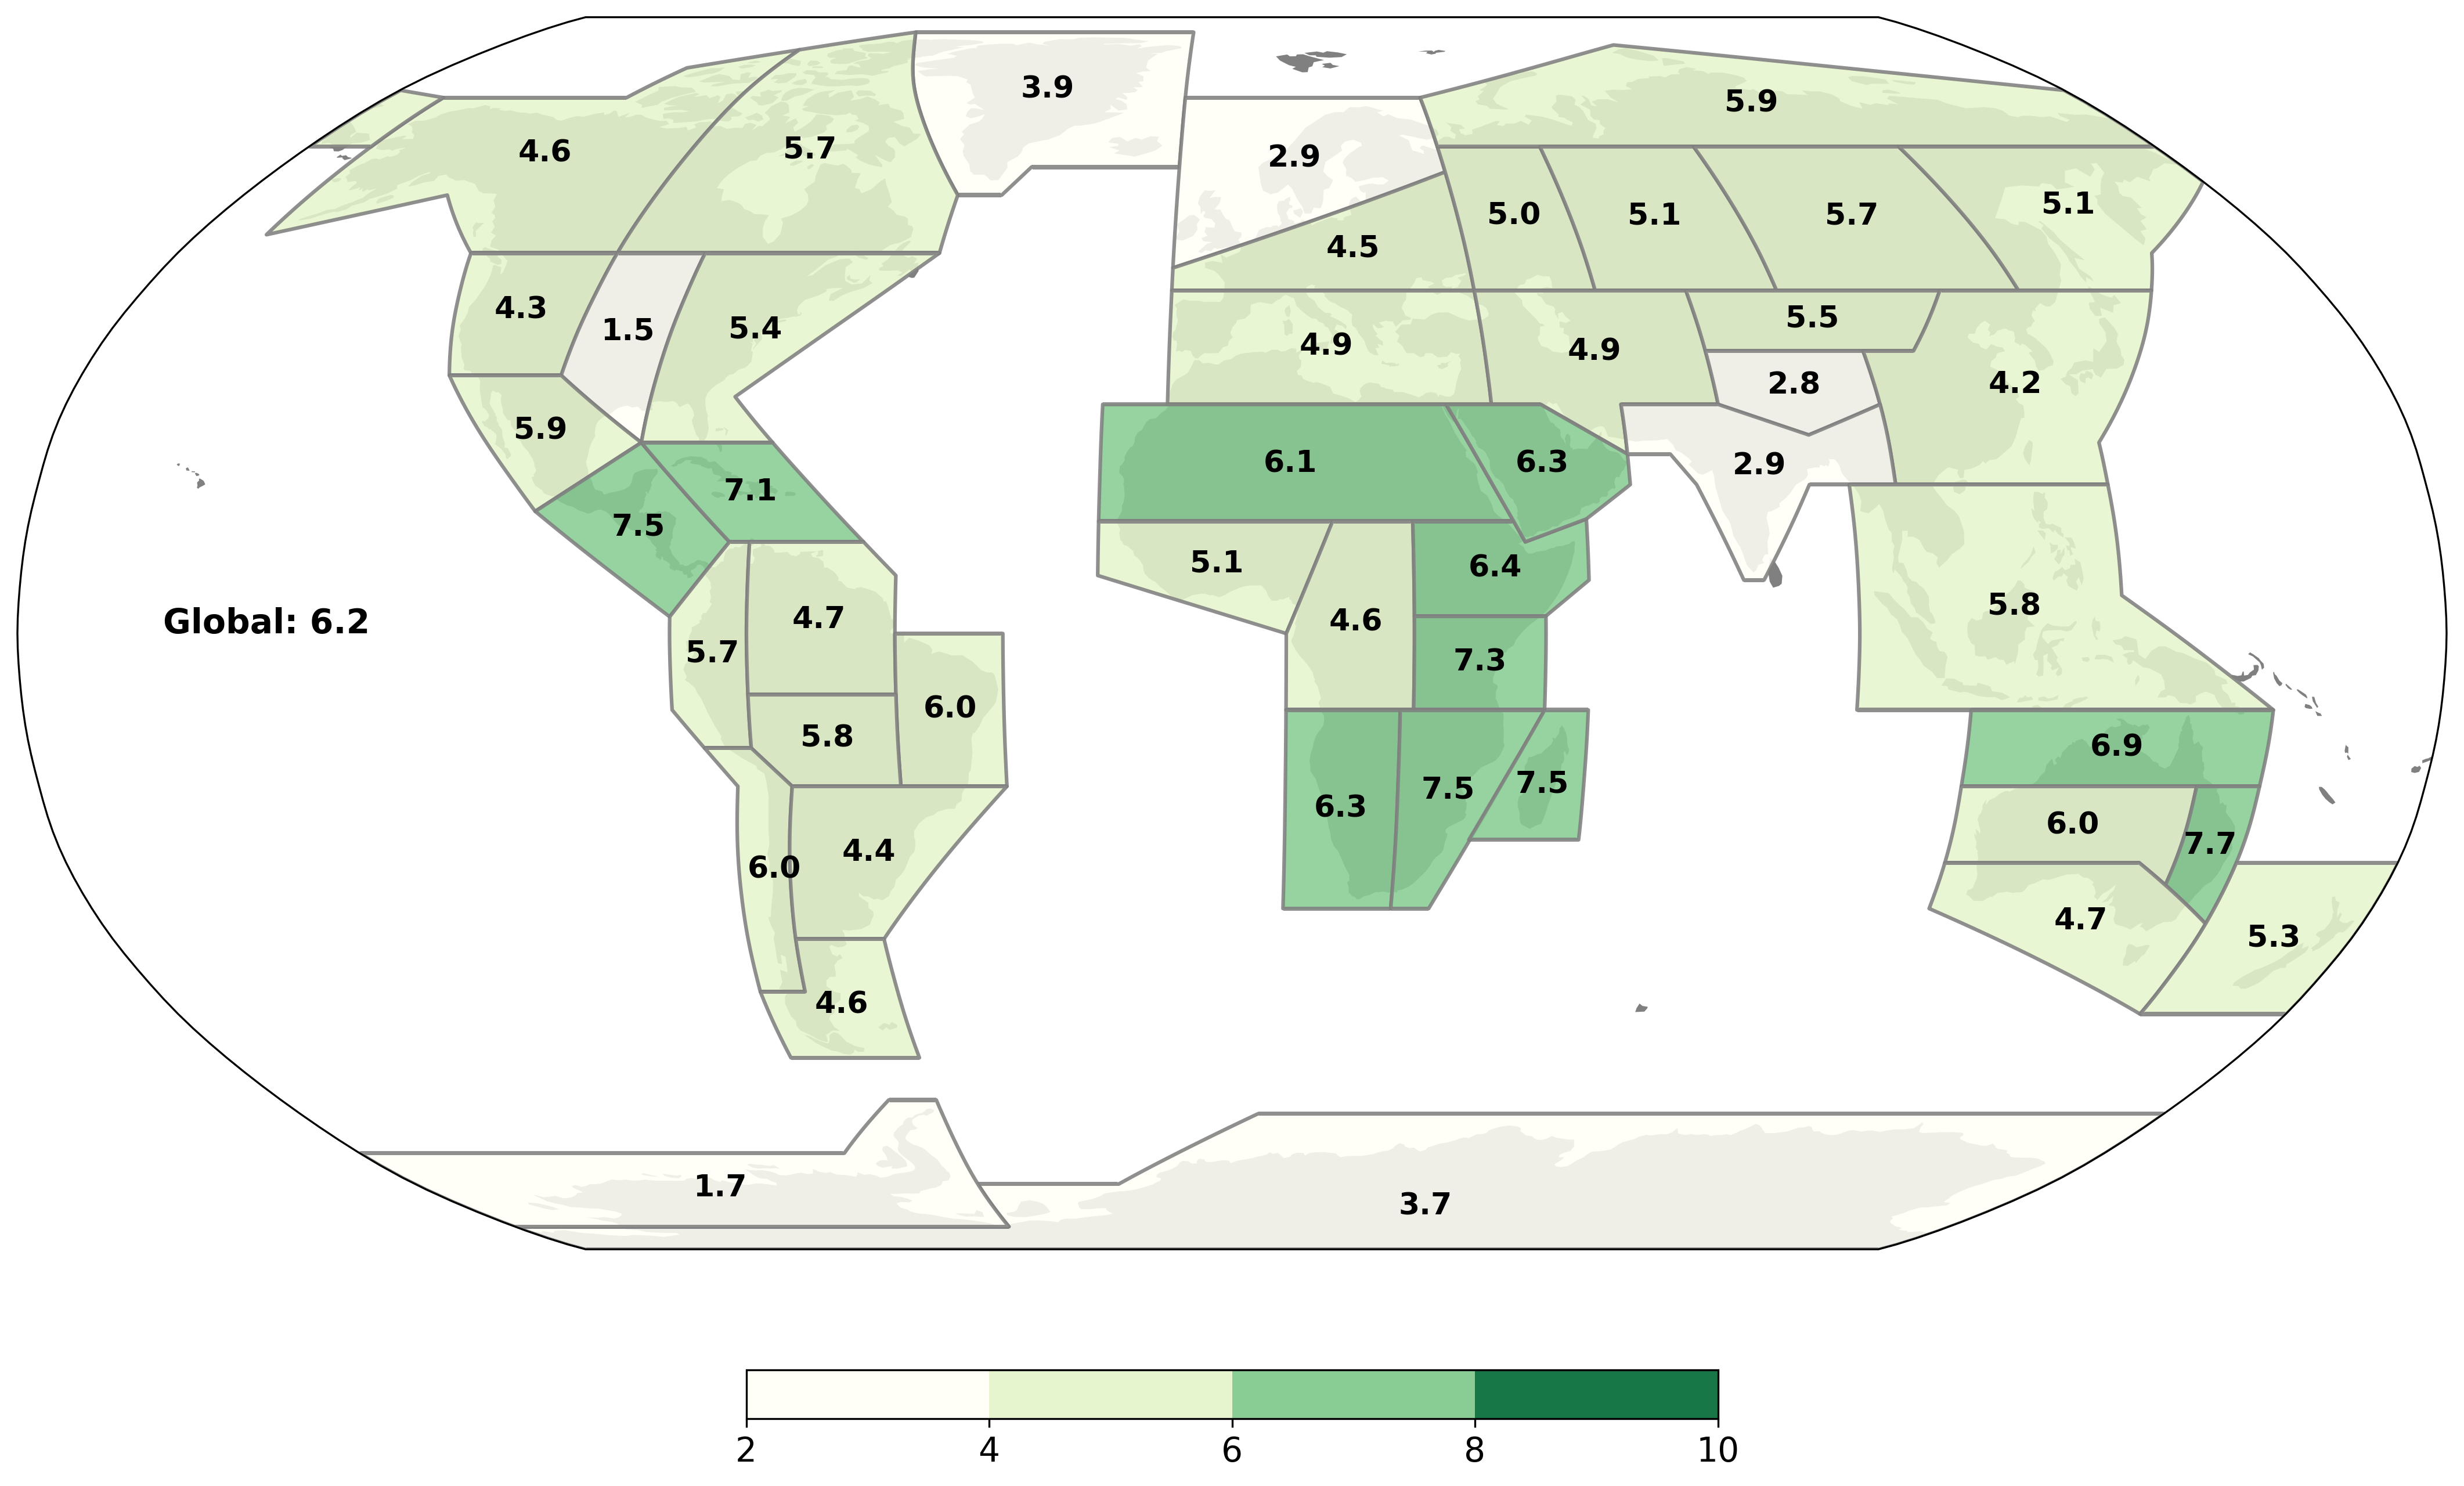

In [32]:
confidence_prior = confidence_all.sel(scheme = 'prior').isel(region = slice(0, 46))
global_prior = confidence_all.sel(scheme = 'prior').isel(region = 46)

# --- Plot panels ---
fig, axes = plt.subplots(1,1, figsize=(18, 18), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)

axes.set_global()
# axes.coastlines(linewidth=0.5)

bounds = np.arange(2, 12, 2)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax_new(axes, confidence_prior, cmap=truncated_cmap, norm=norm, decimals=1, region_shifts = {
    "SWS": (2.0, 0),   # (x_shift, y_shift)
    "EAU": (-0.5, 0) # another example
})

# axes.set_title("Confidence map (Warming magnitude / estimation error (RMSE) in 2016-2025 ref. to 1850-1900)", fontsize=14, fontweight='bold', loc='left')

axes.text(
            0.06, 0.5,
            f"Global: {global_prior:.1f}{unit}",   # unit inserted here
            transform=axes.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )

# --- Shared colorbar ---
# Use a ScalarMappable with the colormap and norm
sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm0)
sm.set_array([])  # required for ScalarMappable

cb = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, shrink=0.4,)
cb.ax.tick_params(labelsize=14)

# cb.set_label("Number of valid grids")

plt.show()
